In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

In [2]:
print('Tensorflow => ',tf.__version__)
print('Keras      => ',tf.keras.__version__)
print('Numpy      => ',np.__version__)

Tensorflow =>  2.10.0
Keras      =>  2.10.0
Numpy      =>  1.25.2


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
tf_device='/gpu:1'

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Visible devices cannot be modified after being initialized


In [6]:
'''
gpus = tf.config.list_physical_devices('GPU')
gpus[0]
tf.config.experimental.set_memory_growth(gpus[0], True)
'''

"\ngpus = tf.config.list_physical_devices('GPU')\ngpus[0]\ntf.config.experimental.set_memory_growth(gpus[0], True)\n"

In [7]:
'''
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
#import requests
from keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.compat.v1.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
'''

'\n#####################################################################\n# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #\n#####################################################################\n\n# allocate 50% of GPU memory (if you like, feel free to change this)\n#import requests\nfrom keras.backend import set_session\nconfig = tf.compat.v1.ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.5\nset_session(tf.compat.v1.Session(config=config))\n\n# watch for any changes in the sample_models module, and reload it automatically\n%load_ext autoreload\n%autoreload 2\n'

In [8]:
BATCH_SIZE=8
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=100

# Hindi Female

## Data Visualization

In [9]:
audio_binary=tf.io.read_file("D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Hindi_fem_Speaker1_english/english/wav/train_hindifullfemale_00001.wav")
audio,_=tf.audio.decode_wav(audio_binary)
waveform=tf.squeeze(audio,axis=-1)
waveform=tf.cast(waveform,tf.float32)
signal=waveform
print(signal.shape)

(208725,)


(208725,)


C:\Users\Anand\AppData\Local\Temp\ipykernel_23192\3761284741.py:18: RuntimeWarning: divide by zero encountered in log
  power_spec=np.log(spec)
C:\Users\Anand\AppData\Local\Temp\ipykernel_23192\3761284741.py:33: RuntimeWarning: divide by zero encountered in log
  power_spec=np.log(spec)


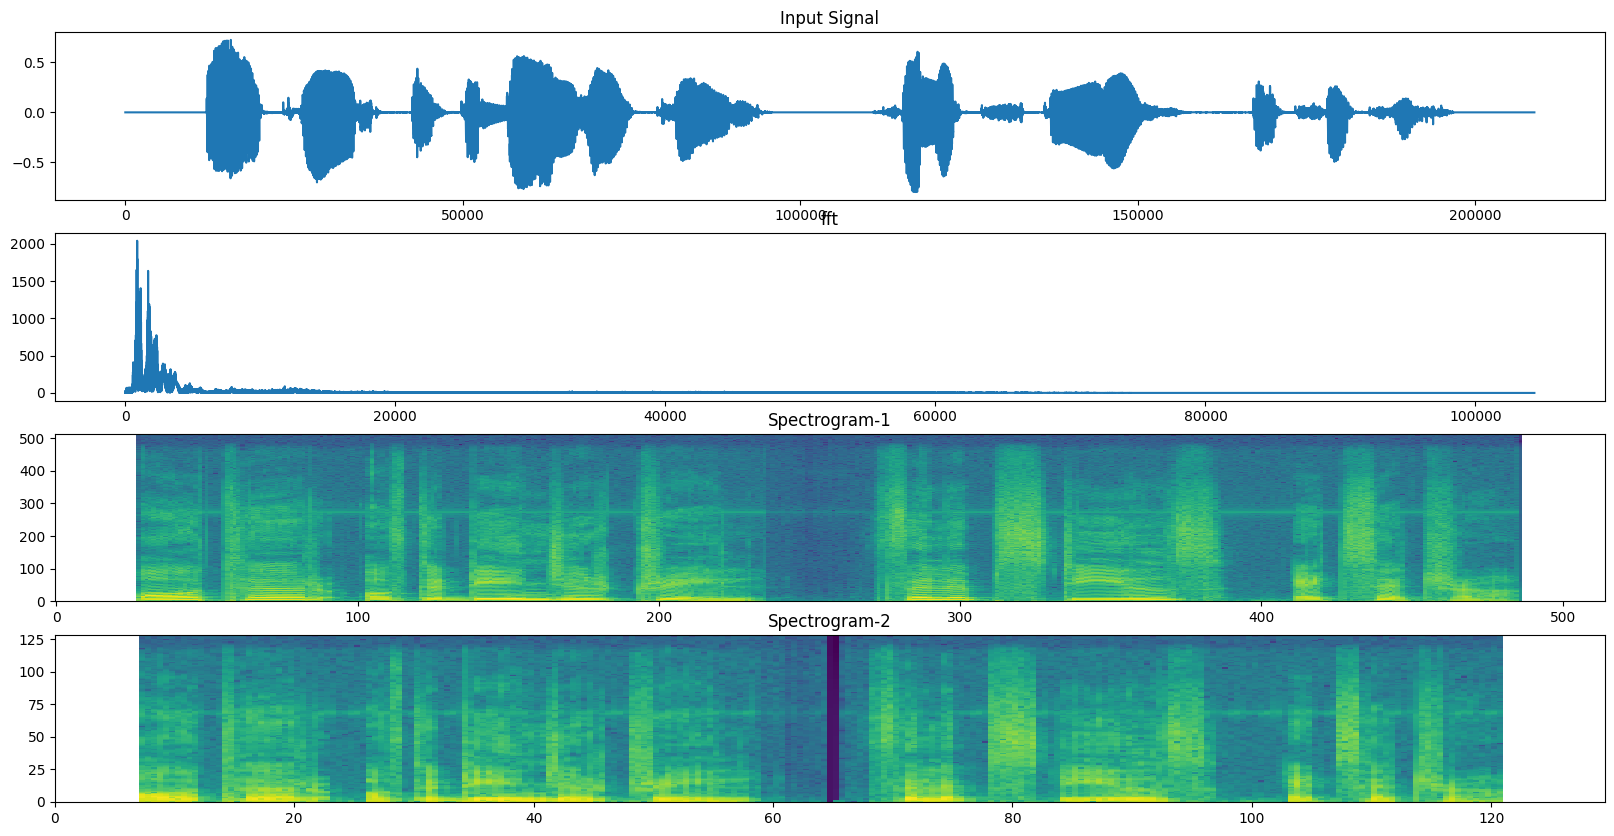

In [10]:
fig,axis=plt.subplots(4,figsize=(20,10))

L=2000
x=tf.linspace(-L//2,L//2,L)
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")

fft=tf.signal.rfft(signal)

axis[1].plot(tf.abs(fft))
axis[1].set_title("fft")


spec=tf.signal.stft(signal,frame_length=1024,frame_step=512,)
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[2].pcolormesh(X,Y,power_spec)
axis[2].set_title("Spectrogram-1")


spec=tf.signal.stft(signal,frame_length=256,frame_step=128, )
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[3].pcolormesh(X,Y,power_spec)
axis[3].set_title("Spectrogram-2")


plt.show()


## Data Preparation

In [11]:
audio_text2={}
csv_path="D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Hindi_fem_Speaker1_english/english/txt.done.data"
with open(csv_path, encoding="utf-8") as f:
  for line in f:
    i=line.strip().split(" \" ")[0].removeprefix("( ")    
    text=line.strip().split(" \" ")[1].removesuffix(' " )')    
    audio_text2[str(i)]=text    

audio_text2

{'train_hindifullfemale_00001': 'Author of the danger trail, Philip Steels, etc.',
 'train_hindifullfemale_00002': 'Not at this particular case, Tom, apologized Whittemore.',
 'train_hindifullfemale_00003': 'For the twentieth time that evening the two men shook hands.',
 'train_hindifullfemale_00004': "Lord, but I'm glad to see you again, Phil.",
 'train_hindifullfemale_00005': 'Will we ever forget it.',
 'train_hindifullfemale_00006': "God bless 'em, I hope I'll go on seeing them forever.",
 'train_hindifullfemale_00007': 'And you always want to see it in the superlative degree.',
 'train_hindifullfemale_00008': 'Gad, your letter came just in time.',
 'train_hindifullfemale_00009': 'He turned sharply, and faced Gregson across the table.',
 'train_hindifullfemale_00010': "I'm playing a single hand in what looks like a losing game.",
 'train_hindifullfemale_00011': 'If I ever needed a fighter in my life I need one now.',
 'train_hindifullfemale_00012': 'Gregson shoved back his chair and

In [12]:
filepaths=["D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Hindi_fem_Speaker1_english/english/wav/"+filename+".wav" for filename in list(audio_text2.keys())]
transcriptions=[audio_text2[str(filename)].lower() for filename in list(audio_text2.keys())]
print(len(filepaths))
print(len(transcriptions))

6541
6541


In [13]:
dataset=tf.data.Dataset.from_tensor_slices((filepaths,transcriptions))

for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Hindi_fem_Speaker1_english/english/wav/train_hindifullfemale_00001.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'author of the danger trail, philip steels, etc.'>)


In [14]:
def decode_audio(audio_binary):
    audio,_=tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio,axis=-1)

In [15]:
vocabulary=[""]+[chr(i) for i in range(97,97+26)]+[".",",","?"," "]
print(vocabulary)
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', ' ']
31


In [16]:
def get_label(label,):
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    return label

In [17]:
def get_spec(filepath,label):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
  spectrogram=tf.abs(spectrogram)
  label=get_label(label)
  return tf.expand_dims(spectrogram,axis=-1),label

In [18]:
processed_dataset = (
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [19]:
train_dataset=processed_dataset.take(int(0.95*len(processed_dataset)))
val_dataset=processed_dataset.skip(int(0.95*len(processed_dataset)))

In [20]:
for i,j in train_dataset.take(1):
  print(i,j)

tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0

## Modeling 

In [21]:
normalization=tf.keras.layers.Normalization()

In [22]:
input_spectrogram=Input((None,129,1), name="input")

x=normalization(input_spectrogram)
x=Conv2D(32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)
x=Conv2D(64,kernel_size=[11,21],strides=[1,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)

x=Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)


output=Dense(len(vocabulary)+1, activation="softmax")(x)

model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech_2_Inspired")
model.summary()

Model: "DeepSpeech_2_Inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization (Normalizatio  (None, None, 129, 1)     3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, None, 65, 32)      14464     
                                                                 
 layer_normalization (LayerN  (None, None, 65, 32)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_1 (Laye  (None, None, 33

In [23]:
def ctc_loss(y_true,y_pred):
  batch_size=tf.shape(y_pred)[0]
  pred_length=tf.shape(y_pred)[1]
  true_length=tf.shape(y_true)[1]

  pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32)
  true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)

  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [24]:
model.compile(
    loss=ctc_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
)

In [25]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ASR_IndicTTS_Hindi_Female_Model-{epoch:03d}.h5")
model_path='D:/CDAC/Project/ASR-using-deepspeech2/ASR_IndicTTS_Hindi_Female_Model_Final.h5'

## Training

In [29]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=N_EPOCHS,  
  callbacks=[checkpoint_cb]  
)

Epoch 1/100
777/777 [==============================] - 1681s 2s/step - loss: 309.5063 - val_loss: 434.8398
Epoch 2/100
777/777 [==============================] - 773s 996ms/step - loss: 205.8715 - val_loss: 415.0282
Epoch 3/100
777/777 [==============================] - 794s 1s/step - loss: 158.3503 - val_loss: 269.4568
Epoch 4/100
777/777 [==============================] - 773s 995ms/step - loss: 97.1014 - val_loss: 216.1055
Epoch 5/100
777/777 [==============================] - 783s 1s/step - loss: 73.8332 - val_loss: 191.2256
Epoch 6/100
777/777 [==============================] - 775s 997ms/step - loss: 61.7457 - val_loss: 174.2203
Epoch 7/100
777/777 [==============================] - 770s 992ms/step - loss: 53.6773 - val_loss: 167.2903
Epoch 8/100
777/777 [==============================] - 762s 981ms/step - loss: 47.6940 - val_loss: 164.5144
Epoch 9/100
777/777 [==============================] - 768s 989ms/step - loss: 42.8456 - val_loss: 164.7146
Epoch 10/100
777/777 [===========

In [29]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=38,  
  callbacks=[checkpoint_cb]  
)

Epoch 1/38
777/777 [==============================] - 1636s 2s/step - loss: 3.6545 - val_loss: 328.2404
Epoch 2/38
777/777 [==============================] - 730s 940ms/step - loss: 3.7516 - val_loss: 325.8013
Epoch 3/38
777/777 [==============================] - 727s 936ms/step - loss: 3.6233 - val_loss: 330.5381
Epoch 4/38
777/777 [==============================] - 743s 956ms/step - loss: 3.5287 - val_loss: 333.2128
Epoch 5/38
777/777 [==============================] - 726s 934ms/step - loss: 3.6908 - val_loss: 329.1169
Epoch 6/38
777/777 [==============================] - 709s 913ms/step - loss: 3.7775 - val_loss: 335.2422
Epoch 7/38
777/777 [==============================] - 729s 938ms/step - loss: 3.9488 - val_loss: 332.7997
Epoch 8/38
777/777 [==============================] - 728s 937ms/step - loss: 3.8139 - val_loss: 341.3702
Epoch 9/38
777/777 [==============================] - 731s 941ms/step - loss: 3.6982 - val_loss: 334.4336
Epoch 10/38
777/777 [===========================

In [30]:
# save model
model.save(model_path)

## Testing

In [ ]:
model.load_weights('D:/CDAC/Project/ASR-using-deepspeech2/ASR_IndicTTS_Hindi_Female_Model_Final.h5')

In [26]:
model.load_weights('ASR_IndicTTS_Hindi_Female_Model-062.h5')

In [31]:
#obtain and decode the acoustic model's predictions
model.load_weights(model_path)

In [27]:
def get_spec_inference(filepath):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)

  spectrogram=tf.abs(spectrogram)

  return tf.expand_dims(spectrogram,axis=-1)

In [28]:
def decode(y_pred):
  batch_size=tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length=tf.shape(y_pred)[1]
  pred_length*=tf.ones([batch_size,],dtype=tf.int32)

  y_pred=tf.one_hot(y_pred,len(vocabulary)+1)
  output=tf.keras.backend.ctc_decode(y_pred,input_length=pred_length,greedy=True)[0][0]

  out=[vocabulary[i] for i in output[0]]
  return ''.join(out)

In [32]:
test_path="D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Hindi_fem_Speaker1_english/english/wav/train_hindifullfemale_00200.wav"
from IPython.display import Audio
# play the audio file
Audio(test_path)

In [33]:
spectrogram=get_spec_inference(test_path)
print(spectrogram.shape)
out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)
out

(1015, 129, 1)
1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(508,), dtype=int64, numpy=
array([31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,  8,  8,  5,  5, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 30, 30,  3, 31, 31, 31, 31, 31, 31, 31, 31, 31, 18, 18, 18, 18,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31,  9,  9,  9,  5, 31, 31, 31, 31, 31,  4,  4,  4,
       30, 30,  1,  1, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 14, 14,  4, 31, 31, 31, 31, 31, 31, 31, 30, 30, 30, 19, 19, 19,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 23, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 21, 21,

In [34]:
out_list=[vocabulary[i] if i!=31 else "[LINK]" for i in out]
out_str="".join(out_list)
print(out_str)

[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]hhee[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]  c[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]rrrr[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]iiie[LINK][LINK][LINK][LINK][LINK]ddd  aa[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]nnd[LINK][LINK][LINK][LINK][LINK][LINK][LINK]   sss[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LI

In [35]:
transcription=decode(tf.expand_dims(out,axis=0))
print(transcription)

tf.Tensor([  1 508], shape=(2,), dtype=int32)
he cried and swung the club wildly.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         


In [ ]:
#%pip list

In [ ]:
# !pip install pyspellchecker
from spellchecker import SpellChecker

spelling = SpellChecker()
def spelling_checks(text):
  correct_result = []
  typo_words = spelling.unknown(text.split())
  for word in text.split():
    if word in typo_words:
      newWord=spelling.correction(word)
      if newWord!=None:
        correct_result.append(newWord)
      else:
        correct_result.append(word)
    else:
      correct_result.append(word)
  return " ".join(correct_result)

corrected_transcription=spelling_checks(transcription)
print(corrected_transcription)

he cried and swung the club wildly
